クックブック: LangGraph 統合

https://langfuse.com/docs/integrations/langchain/example-python-langgraph

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

### Example 1: Simple chat app with LangGraph

In [2]:
from typing import Annotated
 
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from typing_extensions import TypedDict
 
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
 
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]
 
graph_builder = StateGraph(State)
 
llm = ChatOpenAI(model = "gpt-4o-mini", temperature = 0)
 
# チャットボットノード機能は、現在のステートを入力として受け取り、更新されたメッセージリストを返します。これは、すべてのLangGraphノード機能の基本的なパターンです。
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}
 
# 「チャットボット」ノードを追加します。ノードは作業単位を表します。通常は通常のPython関数です
graph_builder.add_node("chatbot", chatbot)
 
# エントリーポイントを追加します。これにより、実行するたびにグラフの作業を開始する場所を指定します
graph_builder.set_entry_point("chatbot")
 
# 終了点を設定します。これにより、グラフに「このノードが実行されるたびに終了できる」と指示します
graph_builder.set_finish_point("chatbot")
 
# グラフを実行できるようにするには、グラフビルダーで「compile()」を呼び出します。これにより、「CompiledGraph」が作成され、状態に対して「invoke」を使用できるようになります
graph = graph_builder.compile()

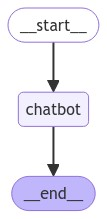

In [3]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

呼び出しのコールバックとしてLangfuseを追加する

In [4]:
from langfuse.callback import CallbackHandler
 
# Langchain(トレース)用のLangfuse CallbackHandlerを初期化する
langfuse_handler = CallbackHandler(
    user_id="user-1234",
    session_id="session-1234",
    trace_name="LangGraph",
    tags=["langchain", "langgraph"]
)
 
for s in graph.stream({"messages": [HumanMessage(content = "Langfuseとは何ですか?")]},
                      config={"callbacks": [langfuse_handler]}):
    print(s)

{'chatbot': {'messages': [AIMessage(content='Langfuseは、主に言語モデルや自然言語処理（NLP）に関連するアプリケーションやサービスを提供するプラットフォームやツールの一つです。具体的には、開発者や企業が自社のアプリケーションに言語モデルを統合し、ユーザーとのインタラクションを向上させるための機能を提供します。\n\nLangfuseの主な機能には、以下のようなものがあります：\n\n1. **トラッキングと分析**: ユーザーのインタラクションを追跡し、どのように言語モデルが使用されているかを分析する機能。\n2. **フィードバック収集**: ユーザーからのフィードバックを収集し、モデルの改善に役立てることができる。\n3. **カスタマイズ**: 特定のニーズに応じて言語モデルをカスタマイズするためのツール。\n\nLangfuseは、企業が言語モデルを効果的に活用し、ユーザー体験を向上させるための支援を行うことを目的としています。具体的な機能やサービス内容は、公式ウェブサイトやドキュメントを参照することで詳細に確認できます。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 293, 'prompt_tokens': 15, 'total_tokens': 308}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_48196bc67a', 'finish_reason': 'stop', 'logprobs': None}, id='run-836c2f12-035a-4d33-a501-a26bdc3617f9-0', usage_metadata={'input_tokens': 15, 'output_tokens': 293, 'total_tokens': 308})]}}


### 例 2: LangGraph を使用したマルチエージェント アプリケーション

ツールを作成する

In [5]:
from typing import Annotated
 
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from datetime import datetime
from langchain.tools import Tool
 
# ウィキペディアを検索するツールを定義する
wikipedia_tool = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())
 
# 現在の日時を返す新しいツールを定義する
datetime_tool = Tool(
    name="Datetime",
    func = lambda x: datetime.now().isoformat(),
    description="Returns the current datetime",
)

ヘルパーユーティリティ

In [6]:
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

def create_agent(llm: ChatOpenAI, system_prompt: str, tools: list):
    # Each worker node will be given a name and some tools.
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor
 
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

エージェントスーパーバイザーの作成

In [7]:
from langchain_core.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
 
members = ["Researcher", "CurrentTime"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)
# 私たちのチームのスーパーバイザーはLLMノードです。次の処理対象のエージェントを選択し、作業が完了したかどうかを判断します。
options = ["FINISH"] + members
 
# openaiの関数呼び出しを使用すると、出力の解析が容易になります。
function_def = {
    "name": "route",
    "description": "Select the next role.",
    "parameters": {
        "title": "routeSchema",
        "type": "object",
        "properties": {
            "next": {
                "title": "Next",
                "anyOf": [
                    {"enum": options},
                ],
            }
        },
        "required": ["next"],
    },
}
 
# Create the prompt using ChatPromptTemplate
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))
 
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
 
# Construction of the chain for the supervisor agent
supervisor_chain = (
    prompt
    | llm.bind_functions(functions=[function_def], function_call="route")
    | JsonOutputFunctionsParser()
)

グラフを構築する

In [8]:
import functools
import operator
from typing import Sequence, TypedDict
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph, START
 
# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str
 
# Add the research agent using the create_agent helper function
research_agent = create_agent(llm, "You are a web researcher.", [wikipedia_tool])
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")
 
# Add the time agent using the create_agent helper function
currenttime_agent = create_agent(llm, "You can tell the current time at", [datetime_tool])
currenttime_node = functools.partial(agent_node, agent=currenttime_agent, name = "CurrentTime")
 
workflow = StateGraph(AgentState)
 
# Add a "chatbot" node. Nodes represent units of work. They are typically regular python functions.
workflow.add_node("Researcher", research_node)
workflow.add_node("CurrentTime", currenttime_node)
workflow.add_node("supervisor", supervisor_chain)
 
# We want our workers to ALWAYS "report back" to the supervisor when done
for member in members:
    workflow.add_edge(member, "supervisor")
 
# Conditional edges usually contain "if" statements to route to different nodes depending on the current graph state.
# These functions receive the current graph state and return a string or list of strings indicating which node(s) to call next.
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)
 
# Add an entry point. This tells our graph where to start its work each time we run it.
workflow.add_edge(START, "supervisor")
 
# To be able to run our graph, call "compile()" on the graph builder. This creates a "CompiledGraph" we can use invoke on our state.
graph_2 = workflow.compile()

呼び出しのコールバックとしてLangfuseを追加する

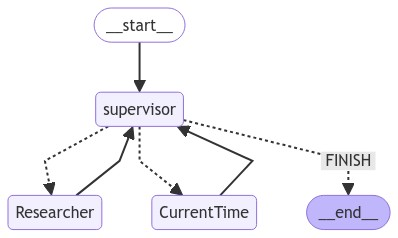

In [9]:
from IPython.display import Image, display

try:
    display(Image(graph_2.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

呼び出しのコールバックとしてLangfuseを追加する

In [10]:
from langfuse.callback import CallbackHandler
 
# Initialize Langfuse CallbackHandler for Langchain (tracing)
langfuse_handler = CallbackHandler(
    user_id="user-1234-1",
    session_id="session-1234-1",
    trace_name="LangGraph-02",
    tags=["langchain", "langgraph"]
)
 
# Add Langfuse handler as callback: config={"callbacks": [langfuse_handler]}
for s in graph_2.stream({"messages": [HumanMessage(content = "光合成のしくみを教えて")]},
                      config={"callbacks": [langfuse_handler]}):
    print(s)
    print("----")

{'supervisor': {'next': 'Researcher'}}
----
{'Researcher': {'messages': [HumanMessage(content='光合成は、光合成生物（主に植物、藻類、シアノバクテリアなど）が光エネルギーを化学エネルギーに変換する生物学的プロセスです。このプロセスは通常、酸素を生成する酸素性光合成を指します。\n\n### 光合成のしくみ\n\n1. **光エネルギーの吸収**:\n   - 光合成は、光合成色素（植物ではクロロフィル）を含む反応中心で始まります。これらの色素は、主に葉の細胞内の葉緑体に存在します。\n   - 光エネルギーが吸収されると、水などの適切な物質から電子が取り除かれ、酸素ガスが生成されます。\n\n2. **ATPとNADPHの生成**:\n   - 水の分解によって放出された水素は、エネルギー生成に関与する重要な分子であるNADPHとATPの生成に使用されます。\n\n3. **カルビン回路**:\n   - 光合成の次の段階では、カルビン回路と呼ばれる光非依存反応が行われます。この過程では、大気中の二酸化炭素が既存の有機化合物（例：リブロースビスリン酸）に取り込まれます。\n   - ATPとNADPHを使用して、生成された化合物が還元され、グルコースなどの炭水化物が形成されます。\n\n### 光合成の重要性\n- 光合成は地球の酸素供給に重要な役割を果たし、複雑な生命の進化を可能にしました。\n- また、光合成は気候プロセスにも重要で、二酸化炭素を吸収し、植物や土壌に固定します。\n\n光合成は1779年にヤン・インゲンハウスによって発見され、植物が光を必要とすることが示されました。', name='Researcher')]}}
----
{'supervisor': {'next': 'FINISH'}}
----


In [11]:
# Add Langfuse handler as callback: config={"callbacks": [langfuse_handler]}
for s in graph_2.stream({"messages": [HumanMessage(content = "現在時刻を教えて！")]},
                      config={"callbacks": [langfuse_handler]}):
    print(s)
    print("----")

{'supervisor': {'next': 'CurrentTime'}}
----
{'CurrentTime': {'messages': [HumanMessage(content='現在の時刻は2024年8月25日 17時28分です。', name='CurrentTime')]}}
----
{'supervisor': {'next': 'FINISH'}}
----


### トレースにスコアとしてスコアを追加する

In [15]:
from langfuse.decorators import langfuse_context, observe
 
# Langfuse observe() decorator to automatically create a trace for the top-level function and spans for any nested functions.
@observe()
def research_agent(user_message):
    # Get callback handler scoped to this observed function
    lf_handler = langfuse_context.get_current_langchain_handler()
 
    # Trace langchain run via the Langfuse CallbackHandler
    response = graph_2.invoke({"messages": [HumanMessage(content=user_message)]},
                        config={"callbacks": [lf_handler]})
 
    # トレース全体にスコアを付ける(例:ユーザーフィードバックを追加する)
    langfuse_context.score_current_trace(
        name = "user-explicit-feedback",
        value = 1,
        comment = "The time is correct!"
        )
 
    return response
research_agent("現在時刻を教えて！")

{'messages': [HumanMessage(content='現在時刻を教えて！'),
  HumanMessage(content='現在の時刻は2024年8月25日 17時38分41秒です。', name='CurrentTime')],
 'next': 'FINISH'}

Langfuse でスコア付きのトレースを表示する

### Langfuseでプロンプトを管理する

In [16]:
from langfuse import Langfuse
 
# Initialize Langfuse client (prompt management)
langfuse = Langfuse()
 
langfuse.create_prompt(
    name="translator_system-prompt-001",
    prompt="You are a translator that translates every input text into japanese.",
    labels=["production"]
)